In [41]:
import pandas as pd
import os
import urllib
import zipfile
import logging
from icecream import ic
from os import path



def downloadYearlyEmpolymentData(year:int):
	"""Download the yearly employment data from the Bureau of Labor Statistic.

	Args:
		 year (int): year of the employment data.

	Returns:
		 data_path (string): path of the downloaded data.
	"""
	data_path = f'./{year}_employment_data'
	if path.exists(data_path):
		logging.info(f'Data path {data_path} already exist.')
		return data_path
	else:
		data_url = f'https://data.bls.gov/cew/data/files/{year}/xls/{year}_all_county_high_level.zip'
		logging.info(f'Start to download employment data from {data_url}.')
		data_path_with_extension = data_path + '.zip'
		# download the dataset from the bureau of labor statistic
		urllib.request.urlretrieve(data_url, data_path_with_extension)
		with zipfile.ZipFile(data_path + '.zip') as zip_ref:
			zip_ref.extractall(data_path)
			os.remove(data_path_with_extension)
		return data_path

In [74]:

def extract_county_data(target_county:str, employment_df):
	"""Clean the employment data frame.

	Args:
		 targetCounty (str): county name.
		 employment_df (dataframe): employment data frame.
	"""
	county_df = employment_df.loc[(employment_df['Area'] == target_county)]
	df = county_df.drop([
		'Qtr',
		'Area Type',
		'Own',
		'St Name',
		'Cnty',
		'St',
		'NAICS'
		], axis='columns')
	return df


def get_county_name(target_county):
	"""Get the county name from the target county.

	Args:
		 target_county (str): target county.

	Returns:
		 county_name (str): county name.
	"""
	county_name = target_county.split()[0]
	return county_name

def get_county_range_data_name(county_name, start_year, end_year):
	"""Get the county range data name.

	Args:
		 county_name (str): county name.
		 start_year (int): start year of the employment data.
		 end_year (int): end year of the employment data.

	Returns:
		 county_range_data_name (str): county range data name.
	"""
	return f'./{county_name}/{county_name}_range_{start_year}_{end_year}_employment_data.csv' 

def clean_county_data(target_county, year, employment_df):
	"""Save the concatenated county data to a csv file.
	"""
	county_name = target_county.split()[0]
	county_data_path = f'./{county_name}'

	# create directory for the county data
	if not path.exists(county_data_path):
		os.mkdir(county_data_path)
	
	dict_key = county_name + str(year)
	county_df_path = f'./{county_name}/{dict_key}_employment_data.csv'

		
	if path.exists(county_df_path):
		logging.info(f'County data {county_df_path} already exist, read {dict_key} from file.')
	else:
		extract_county_data(target_county, employment_df).to_csv(county_df_path, index=False)
		


# concatenate the county data
def concatenate_county_data(county_name, start_year, end_year):
	county_yearly_data = []
	for year in range(start_year, end_year + 1):
		county_df_path = f'./{county_name}/{county_name}{year}_employment_data.csv'
		county_yearly_data.append(pd.read_csv(county_df_path))
	return pd.concat(county_yearly_data)


def get_counties_employment_data(target_counties, start_year, end_year):
	"""Get the employment data for the target counties.

	Args:
		 target_counties (list): list of target counties.
		 start_year (int): start year of the employment data.
		 end_year (int): end year of the employment data.

	"""
	for year in range(start_year, end_year + 1):
		# download the yearly employment data from the Bureau of Labor Statistic
		data_path = f'./{year}_employment_data'
		downloadYearlyEmpolymentData(year)

		# read raw data as dataframe
		new_employmen_df = pd.read_excel(f'{data_path}/allhlcn{year - 2000}.xlsx')

		for target_county in target_counties:
			clean_county_data(target_county, year, new_employmen_df)
	
	for target_county in target_counties:
		county_name = get_county_name(target_county)
		county_range_data_name = get_county_range_data_name(county_name, start_year, end_year)


		if path.exists(county_range_data_name):
			logging.info(f'County range data {county_range_data_name} already exist.')
		else:
			concatenate_county_data(county_name, start_year, end_year).sort_values('Year').to_csv(county_range_data_name, index=False)


# start_year = 2012
# end_year = 2021

# target_counties = ['Travis County, Texas']
# get_counties_employment_data(target_counties, start_year, end_year)



/var/folders/vm/fww8xl5j1wndbwkk7qhwtlfr0000gn/T/ipykernel_84854/1290135797.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Average New Employment'] = df['Annual Average Employment'] - df.loc[0, 'Annual Average Employment']
/var/folders/vm/fww8xl5j1wndbwkk7qhwtlfr0000gn/T/ipykernel_84854/1290135797.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Annual Average Employment Increase Rate'] = df['Annual Average Employment'].pct_change()


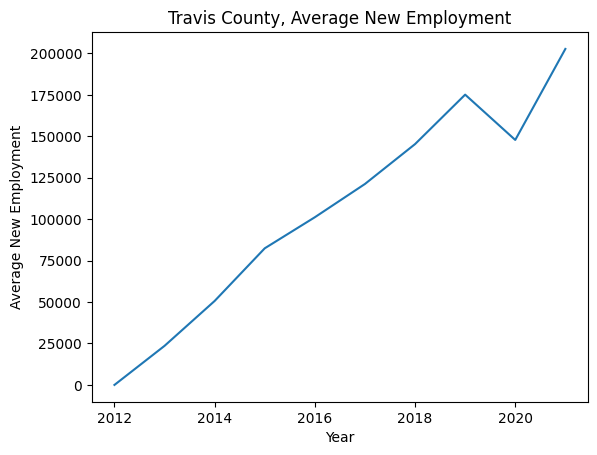

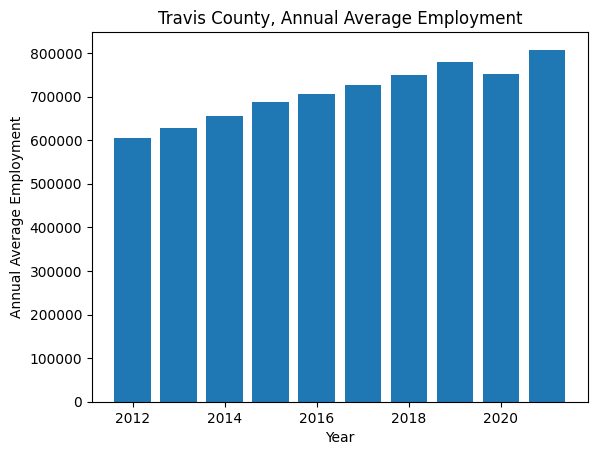

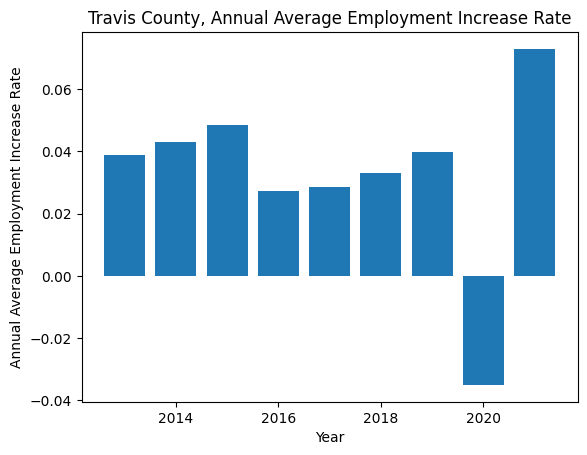

In [57]:
import matplotlib.pyplot as plt


# select df by column value
def select_df_by_column_value(df, column_name, value):
	return df.loc[df[column_name] == value]

# select df by columns values
def select_df_by_columns_values(df, columns_values):
	for column_name, value in columns_values.items():
		df = select_df_by_column_value(df, column_name, value)
	return df

# create new employment column for the df
def create_new_empolyment_column(df):
	df['Average New Employment'] = df['Annual Average Employment'] - df.loc[0, 'Annual Average Employment']
	return df

# calculate df 'Annual Average Employment' columne increase rate as new column
def create_annual_average_employment_increase_rate(df):
	df['Annual Average Employment Increase Rate'] = df['Annual Average Employment'].pct_change()
	return df
	

# get df value by column name and row index
def get_df_value_by_column_name_and_row_index(df, column_name, row_index):
	return df.loc[row_index, column_name]

# get df minimum value by column name
def get_df_min_value_by_column_name(df, column_name):	
	return df[column_name].min()

# plot df in a bar chart
def plot_df_bar(df, x_column, y_column, title, x_label, y_label):
	fig, ax = plt.subplots()
	ax.bar(df[x_column], df[y_column])
	ax.set_title(title)
	ax.set_xlabel(x_label)
	ax.set_ylabel(y_label)
	plt.show()

# plot df in a line chart
def plot_df_line(df, x_column, y_column, title, x_label, y_label):
	fig, ax = plt.subplots()
	ax.plot(df[x_column], df[y_column])
	ax.set_title(title)
	ax.set_xlabel(x_label)
	ax.set_ylabel(y_label)
	plt.show()


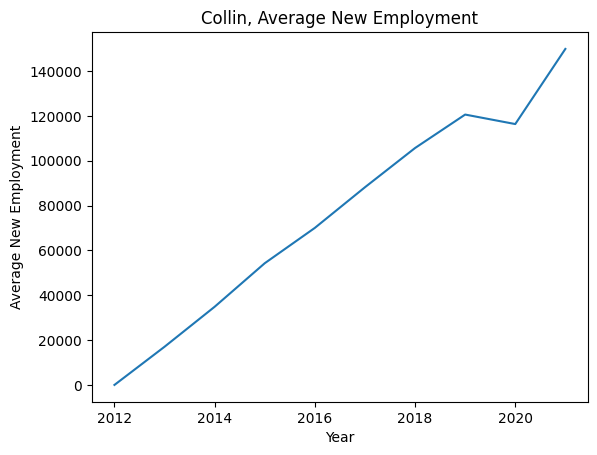

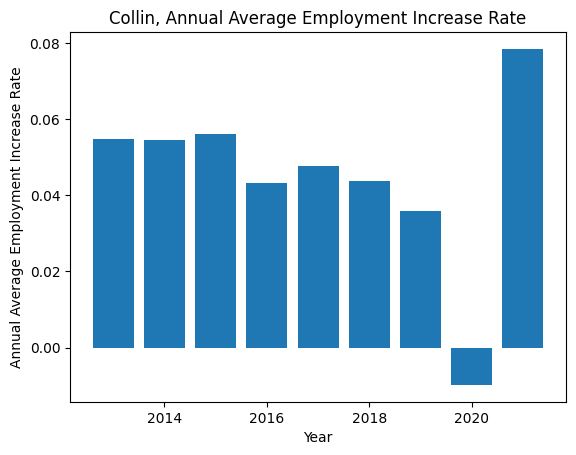

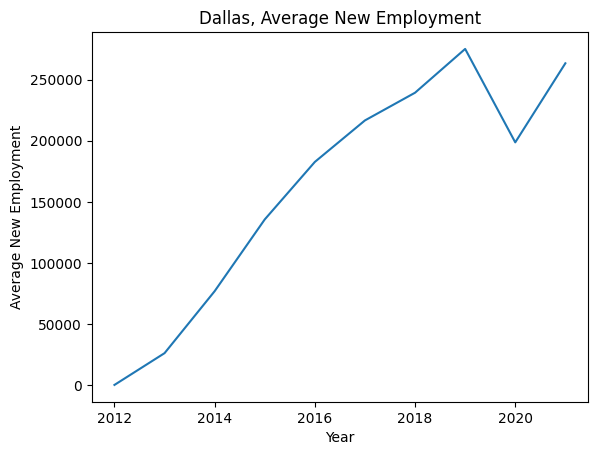

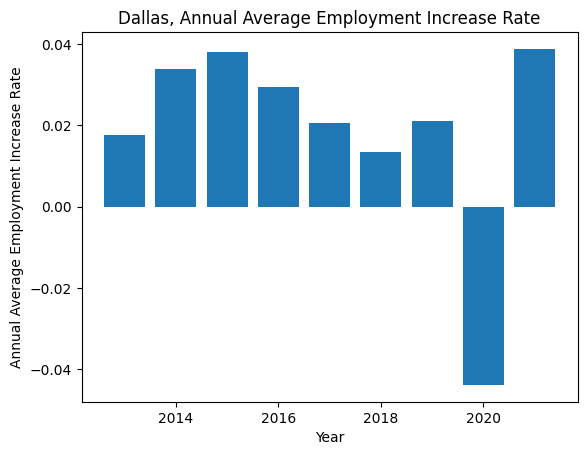

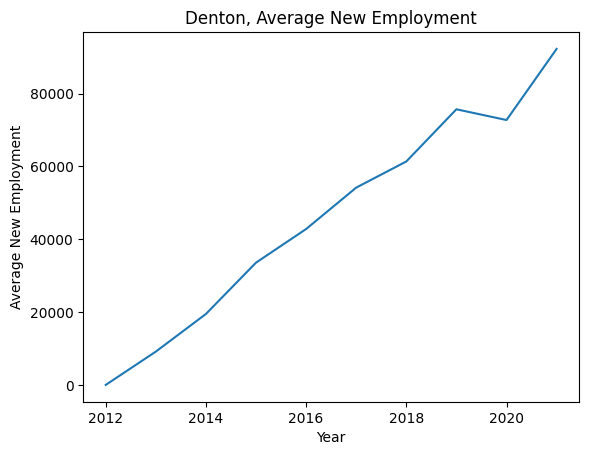

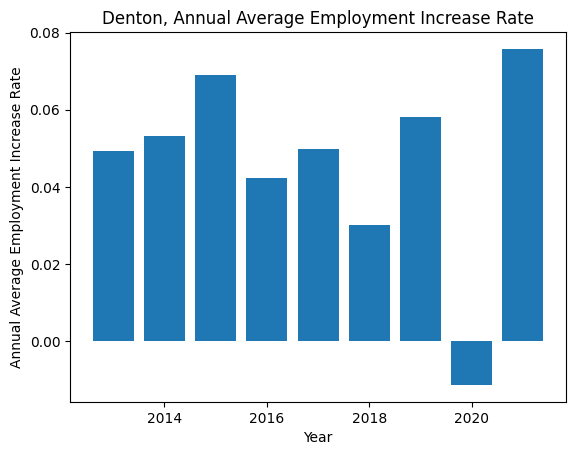

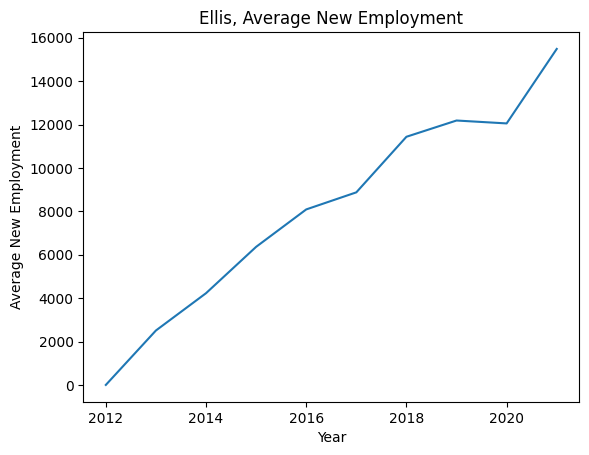

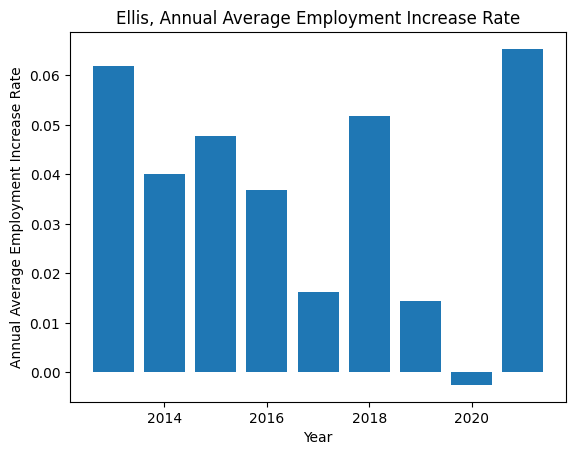

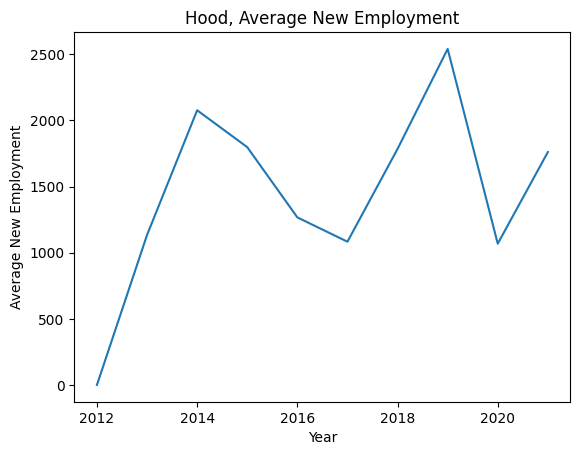

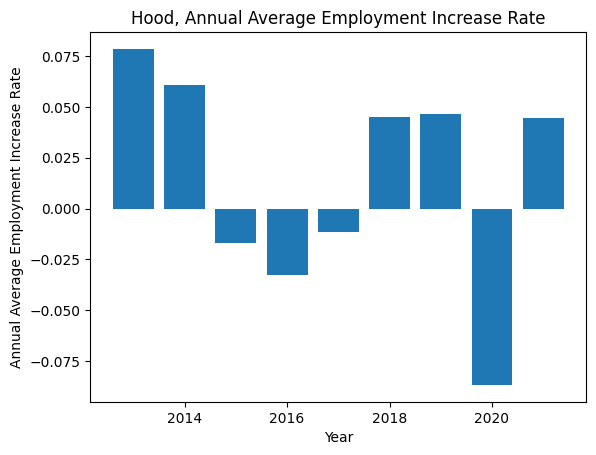

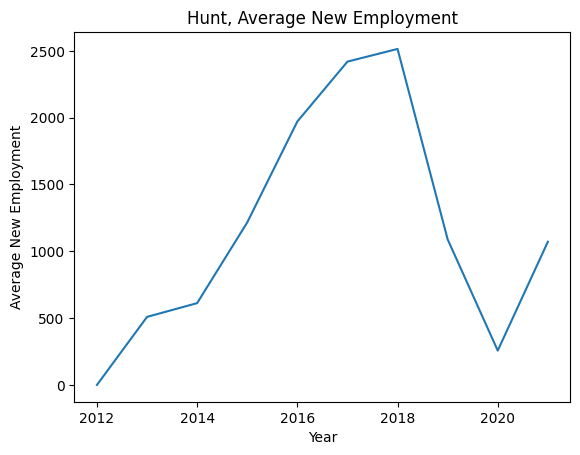

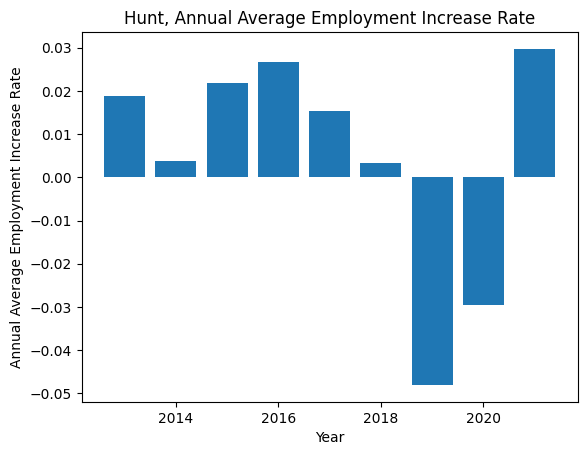

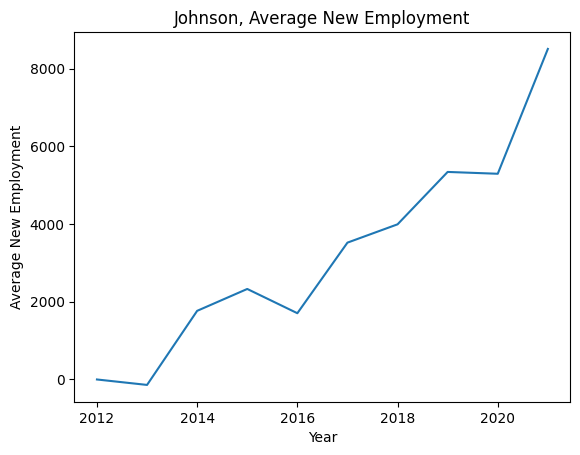

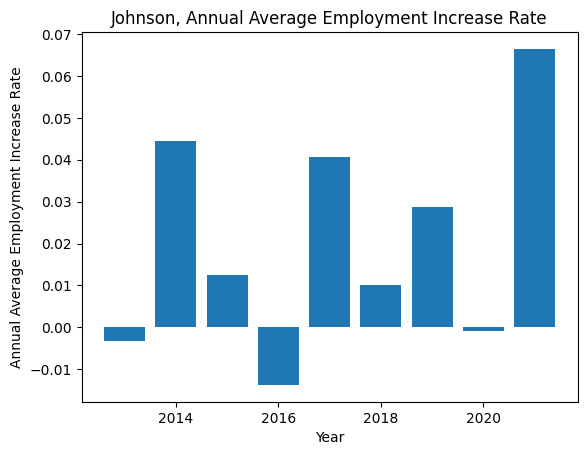

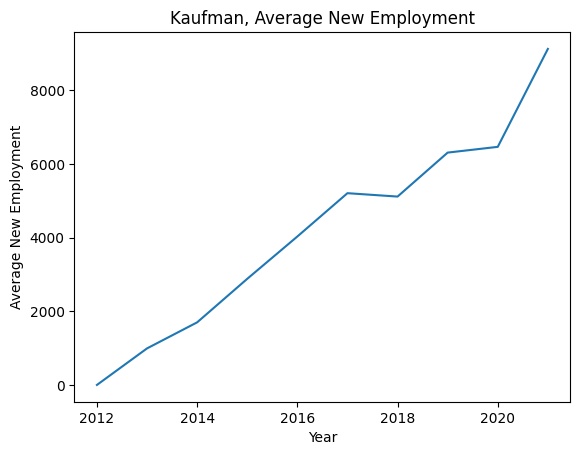

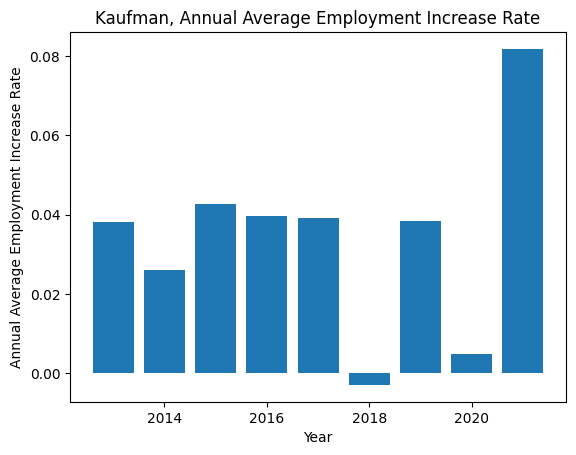

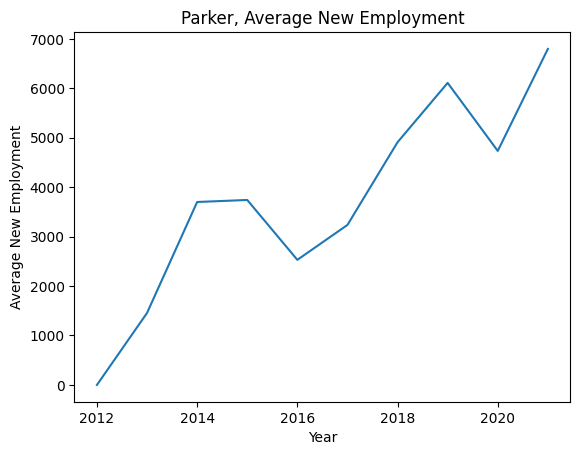

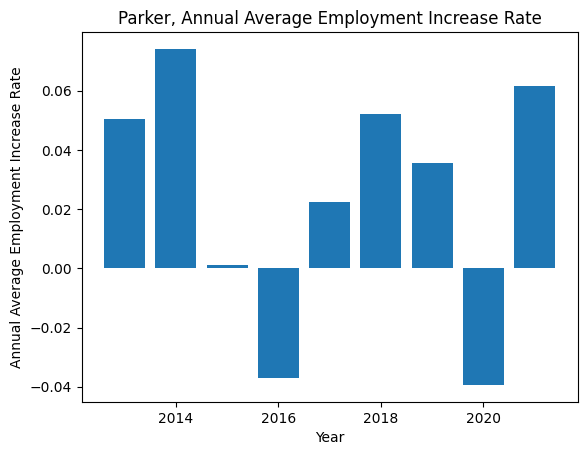

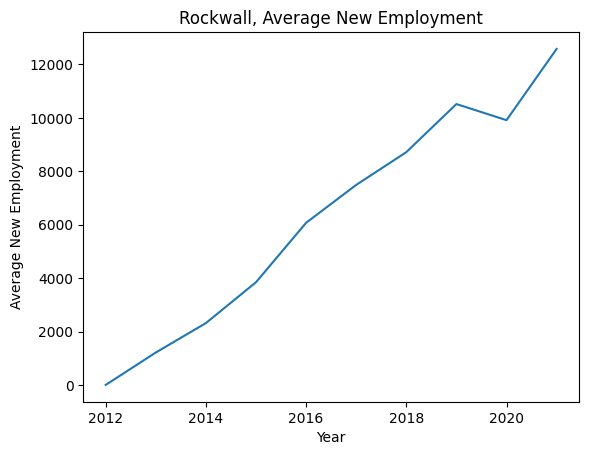

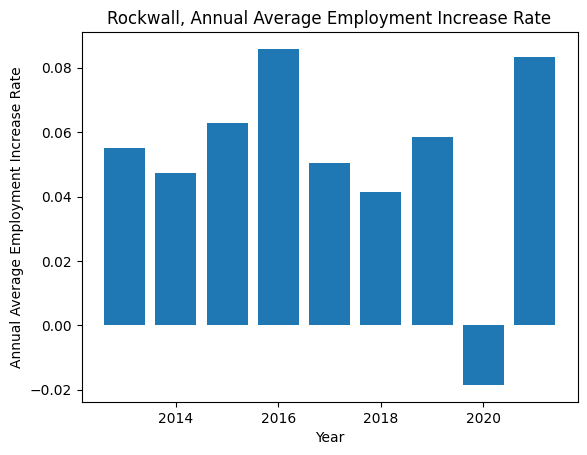

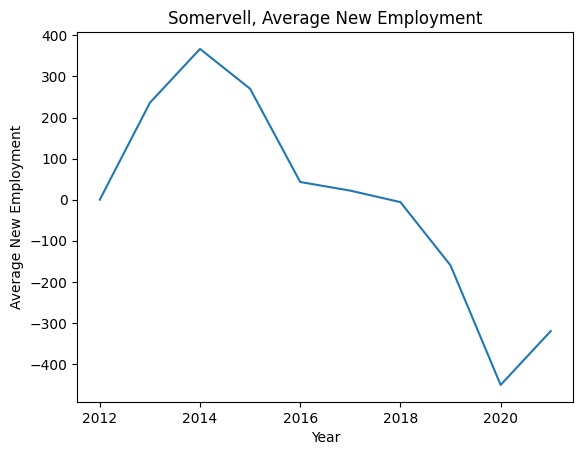

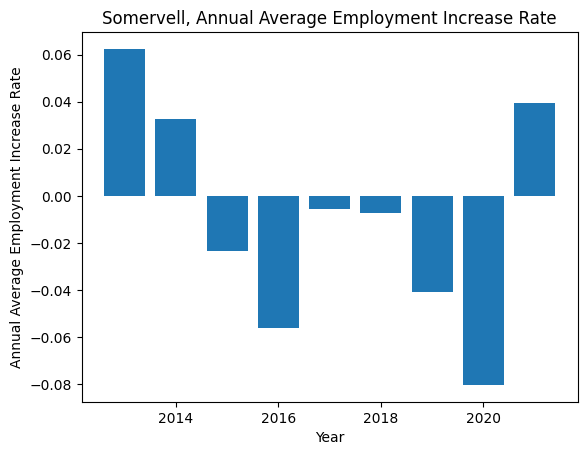

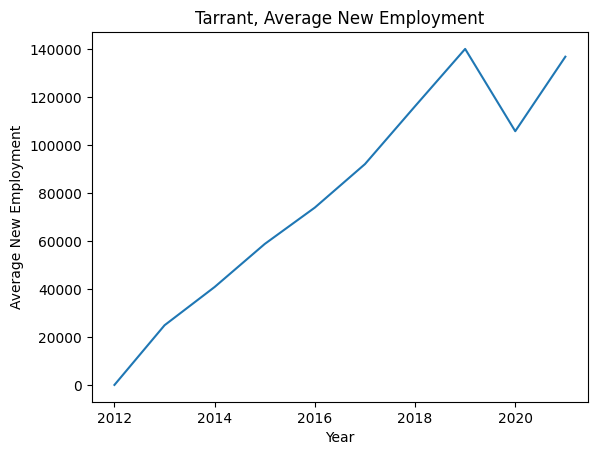

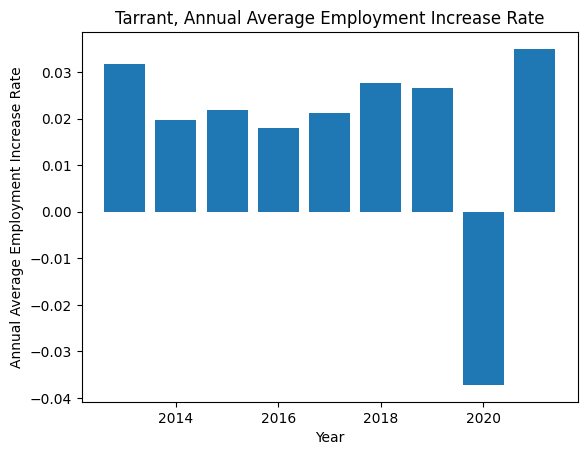

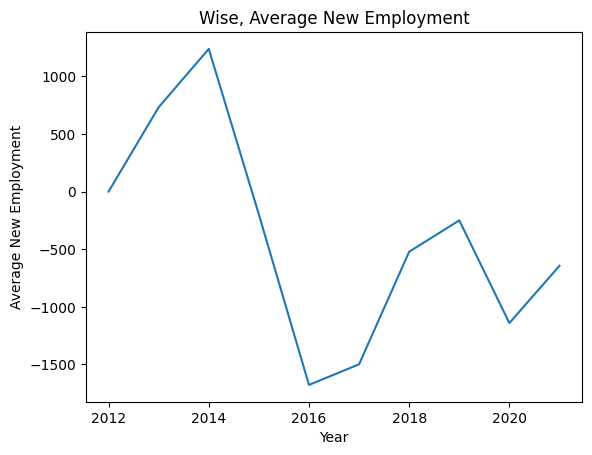

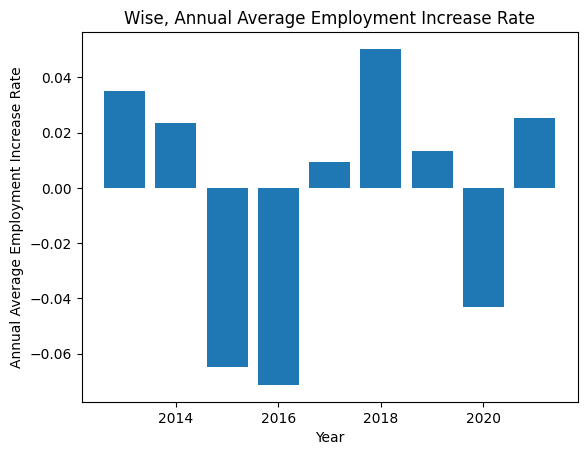

In [134]:
# load the csv qcewqcew-county-msa-csa-crosswalk-csv.cvs as dataframe
county_msa_csa_df = pd.read_csv('./qcew-county-msa-csa-crosswalk-csv.csv',engine='python',encoding='latin1')

# select df County Title based on MSA Title as list
def select_df_by_msa_title(df, msa_title):
	return df.loc[df['MSA Title'] == msa_title, 'County Title'].tolist()
	

start_year = 2012
end_year = 2021
data_filter = {'Ownership': 'Total Covered'}
target_msa = 'Dallas-Fort Worth-Arlington, TX'


target_counties = select_df_by_msa_title(county_msa_csa_df, target_msa) 
get_counties_employment_data(target_counties, start_year, end_year)

for target_county in target_counties:
	county_name = get_county_name(target_county)
	county_range_df = pd.read_csv(get_county_range_data_name(county_name, start_year, end_year))
	df = select_df_by_columns_values(county_range_df, data_filter).sort_values('Year')
	df = create_new_empolyment_column(df)
	df = create_annual_average_employment_increase_rate(df)
	plot_df_line(df, 'Year', 'Average New Employment', f'{county_name}, Average New Employment', 'Year', 'Average New Employment')
	plot_df_bar(df, 'Year', 'Annual Average Employment Increase Rate', f'{county_name}, Annual Average Employment Increase Rate', 'Year', 'Annual Average Employment Increase Rate')


/var/folders/vm/fww8xl5j1wndbwkk7qhwtlfr0000gn/T/ipykernel_84854/3296966222.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], format='%m/%Y')


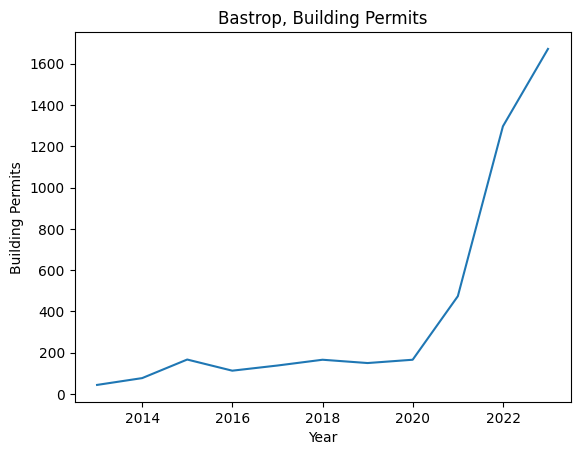

/var/folders/vm/fww8xl5j1wndbwkk7qhwtlfr0000gn/T/ipykernel_84854/3296966222.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], format='%m/%Y')


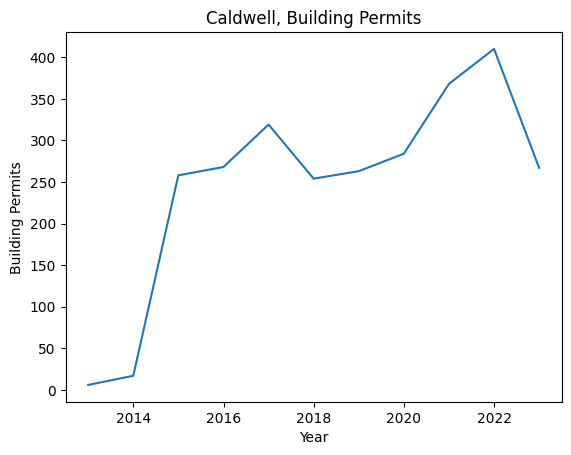

/var/folders/vm/fww8xl5j1wndbwkk7qhwtlfr0000gn/T/ipykernel_84854/3296966222.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], format='%m/%Y')


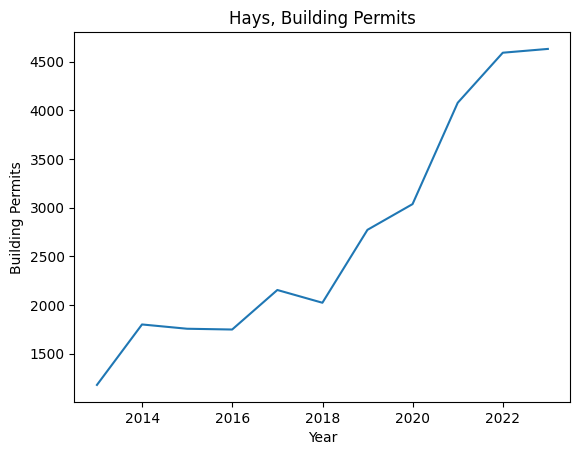

/var/folders/vm/fww8xl5j1wndbwkk7qhwtlfr0000gn/T/ipykernel_84854/3296966222.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], format='%m/%Y')


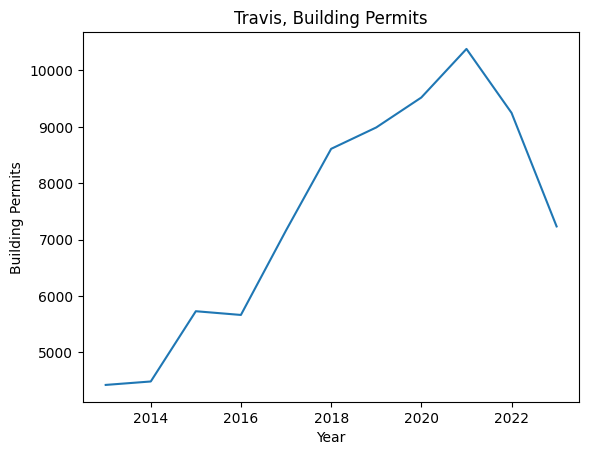

/var/folders/vm/fww8xl5j1wndbwkk7qhwtlfr0000gn/T/ipykernel_84854/3296966222.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'], format='%m/%Y')


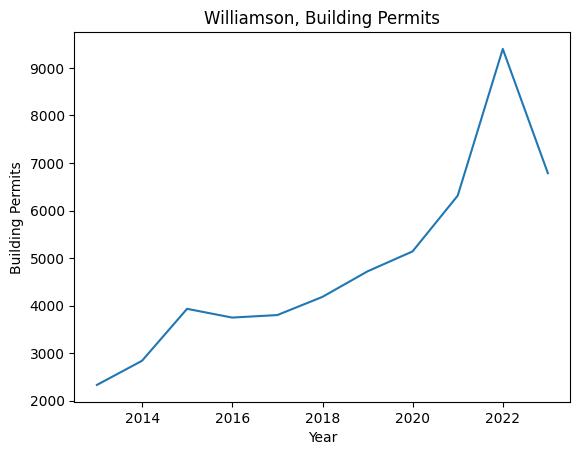

,f1units,f24units,f5units,date
date,,,,
2012-12-31,2330.0,69.0,1301.0,2012-12-31
2013-12-31,2838.0,22.0,734.0,2013-12-31
2014-12-31,3931.0,76.0,861.0,2014-12-31
2015-12-31,3747.0,70.0,1708.0,2015-12-31
2016-12-31,3800.0,116.0,1501.0,2016-12-31


In [129]:
# load the csv dataPermit_full.csv as dataframe
dataPermit_full_df = pd.read_csv('./dataPermit_full.csv') 

# select the dataPermit_full_df by county name
def select_dataPermit_full_df_by_county_name(county_name):
	return dataPermit_full_df.loc[dataPermit_full_df['area'] == county_name]

# select the dataPermit_full_df by date range
def select_dataPermit_full_df_by_date_range(df, start_date, end_date):
	# define column of data type as date which has format as 01/1980
	df['date'] = pd.to_datetime(df['date'], format='%m/%Y')
	return df.loc[(df['date'] >= start_date) & (df['date'] <= end_date)]

# select the dataPermit_full_df by county name and date range
def select_dataPermit_full_df_by_county_name_and_date_range(county_name, start_date, end_date):
	return select_dataPermit_full_df_by_date_range(select_dataPermit_full_df_by_county_name(county_name), start_date, end_date)

import datetime

start_date = datetime.datetime(2012, 1, 1)
end_date = datetime.datetime(2022, 11, 1)
for target_county in target_counties:
	county_name = get_county_name(target_county)
	df = select_dataPermit_full_df_by_county_name_and_date_range(county_name, start_date, end_date)
	# select columns of df
	df = df[['date', 'f1units', 'f24units', 'f5units']]
	# aggregate monthly data to yearly data
	df = df.groupby(pd.Grouper(key='date', freq='Y')).sum()
	df['date'] = df.index
	plot_df_line(df, 'date', 'f1units', f'{county_name}, Building Permits', 'Year', 'Building Permits')


In [116]:
df.head()

,date,f1units,f24units,f5units
2230,2012-01-01,3.0,0.0,0.0
2231,2012-02-01,1.0,0.0,0.0
2232,2012-03-01,4.0,0.0,0.0
2233,2012-04-01,3.0,0.0,0.0
2234,2012-05-01,2.0,0.0,0.0


In [20]:
EMPLOYMENT_SECTOR = [
    '101 Goods-producing',
    '1011 Natural resources and mining',
    '1012 Construction',
    '1013 Manufacturing',
    '102 Service-providing',
    '1021 Trade, transportation, and utilities',
    '1022 Information',
    '1023 Financial activities',
    '1024 Professional and business services',
    '1025 Education and health services',
    '1026 Leisure and hospitality',
    '1027 Other services',
    '1029 Unclassified'
]



print(df[5:])

## filter data on yearly basis
def filter_yearly_data(df):
    """Filter the employment data frame by year.

    Args:
         df (dataframe): employment data frame.
    """

    yearly_df = df.groupby(df.index.str[:4]).sum()
    return yearly_df


       Year                  Area                                   Industry  \
49136  2022  Travis County, Texas                        101 Goods-producing   
49137  2022  Travis County, Texas          1011 Natural resources and mining   
49138  2022  Travis County, Texas                          1012 Construction   
49139  2022  Travis County, Texas                         1013 Manufacturing   
49140  2022  Travis County, Texas                      102 Service-providing   
49141  2022  Travis County, Texas  1021 Trade, transportation, and utilities   
49142  2022  Travis County, Texas                           1022 Information   
49143  2022  Travis County, Texas                  1023 Financial activities   
49144  2022  Travis County, Texas    1024 Professional and business services   
49145  2022  Travis County, Texas         1025 Education and health services   
49146  2022  Travis County, Texas               1026 Leisure and hospitality   
49147  2022  Travis County, Texas       